   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.7 MB/s eta 0:00:00


In [1]:
import chess
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# First Step: Encode

In [2]:
pieces = list('rnbqkpRNBQKP.')
def one_hot_encode_piece(piece):
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}    
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

def encode_board(board):
    # first lets turn the board into a string\n    
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        for piece in row:
            board_list.append(one_hot_encode_piece(piece))
    return np.array(board_list)

def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

In [3]:
df = pd.read_csv('D:/AI/Chess/ChessApp/Chess/csv_data/train.csv')
test_df= pd.read_csv('D:/AI/Chess/ChessApp/Chess/csv_data/test.csv')
df.shape,test_df.shape

((1979383, 2), (1000, 1))

In [4]:
test_df.columns

Index(['FEN\tEvaluation'], dtype='object')

In [5]:
split_train=0.6 #the share of the dataset loaded kept for training
split_val=0.05 #the share of the dataset loaded kept for validation
n=df.shape[0]
m_train,m_val=int(n*split_train),int(n*split_val)
train_df = df[:m_train]
val_df = df[-m_val:]
train_df.shape,val_df.shape

((1187629, 2), (98969, 2))

In [6]:
# We'll stack all our encoded boards into a single numpy array
expected_time=21*(m_train+m_val)/(40000)
print('Expected Time: ',round(expected_time),'s')
st=time.time()
X_train = np.stack(train_df['FEN'].apply(encode_fen_string))
y_train = train_df['Evaluation']
X_val = np.stack(val_df['FEN'].apply(encode_fen_string))
y_val = val_df['Evaluation']
X_test = np.stack(test_df['FEN\tEvaluation'].apply(encode_fen_string))
print('Time elapsed: ',round(time.time()-st),'s')

Expected Time:  675 s
Time elapsed:  203 s


# Intermediate Step: Initialize the weights of the MLP to the "standard evaluation fonction"

I initialize the weights such that before fitting, the model computes the evaluation by counting the points of each side   (100 for a white pawn, -500 for a black rook, etc...)


In [7]:
k=4
pieces = list('rnbqkpRNBQKP.')
weights=10**(-k)*np.array([-500,-300,-300,-900,-500,-100,500,300,300,900,500,100,0])

In [8]:
import tensorflow as tf

array1=np.zeros((64*13,256))
for n in range(64*13):
    square=n//13
    piece=n%13
    array1[n][square]=weights[piece]
initializer_1 = tf.keras.initializers.Constant(array1)  

#
#

array2=np.eye(256,64)
initializer_2 = tf.keras.initializers.Constant(array2)  

#
#

#
#

array3=np.eye(64)
initializer_3 = tf.keras.initializers.Constant(array3)  

#
#
array4=np.zeros((64,8))
for n in range(64):
    row=n//8
    array4[n][row]=1
initializer_4 = tf.keras.initializers.Constant(array4)  
array2.shape

#
#

array5=10**k*np.ones((8,1))
initializer_5 = tf.keras.initializers.Constant(array5)



In [9]:
input0=X_train[0].reshape(-1)
input1=array1.T@input0
input2=array2.T@input1
input3=array3.T@input2
input4=array4.T@input3
input5=array5.T@input4
input1.shape,input2.shape,input3.shape,input4.shape
array1.shape,array2.shape,array3.shape,array4.shape,array5.shape


((832, 256), (256, 64), (64, 64), (64, 8), (8, 1))

# Last Step: Build and fit the model

In [10]:
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Lambda

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_initializer=initializer_1),
    tf.keras.layers.Lambda(tf.keras.activations.tanh),
    tf.keras.layers.Dense(64, kernel_initializer=initializer_2),
    tf.keras.layers.Lambda(tf.keras.activations.tanh),
    tf.keras.layers.Dense(64, kernel_initializer=initializer_3),
    tf.keras.layers.Lambda(tf.keras.activations.tanh),
    tf.keras.layers.Dense(8, kernel_initializer=initializer_4),
    tf.keras.layers.Lambda(tf.keras.activations.tanh),
    tf.keras.layers.Dense(1, kernel_initializer=initializer_5)])

learning_rate=2e-4
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss='mean_absolute_error')

In [11]:
# from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])


Epoch 1/40

4640/4640 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 536.8948 - val_loss: 217.8388
Epoch 2/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 228.1934 - val_loss: 227.9819
Epoch 3/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 212.6056 - val_loss: 215.5844
Epoch 4/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 202.8824 - val_loss: 198.1054
Epoch 5/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 196.0495 - val_loss: 184.6308
Epoch 6/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 189.6064 - val_loss: 224.1395
Epoch 7/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 185.3196 - val_loss: 180.4544
Epoch 8/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 181.0403 - val_loss: 209.5122
Epoch 9/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 177.2651 - val_loss: 191.2142
Epoch 10/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 174.7251 - val_loss: 176.2171
Epoch 11/40
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 173.

# Analyze the results

In [12]:
y_pred_val=model.predict(X_val)[:,0]

3093/3093 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step


In [13]:
from sklearn.metrics import mean_absolute_error
print('MAE Score: ', mean_absolute_error(y_pred_val,y_val))

MAE Score:  154.89437866210938


In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np


# Round the predicted values to integers
y_pred_val_rounded = np.round(y_pred_val/100).astype(int)

# Round the actual values to integers
y_val_rounded = np.array(np.round(y_val/100).astype(int))

In [15]:
def clip(x):
    return(min(10,max(x,-10)))

clip=np.vectorize(clip)

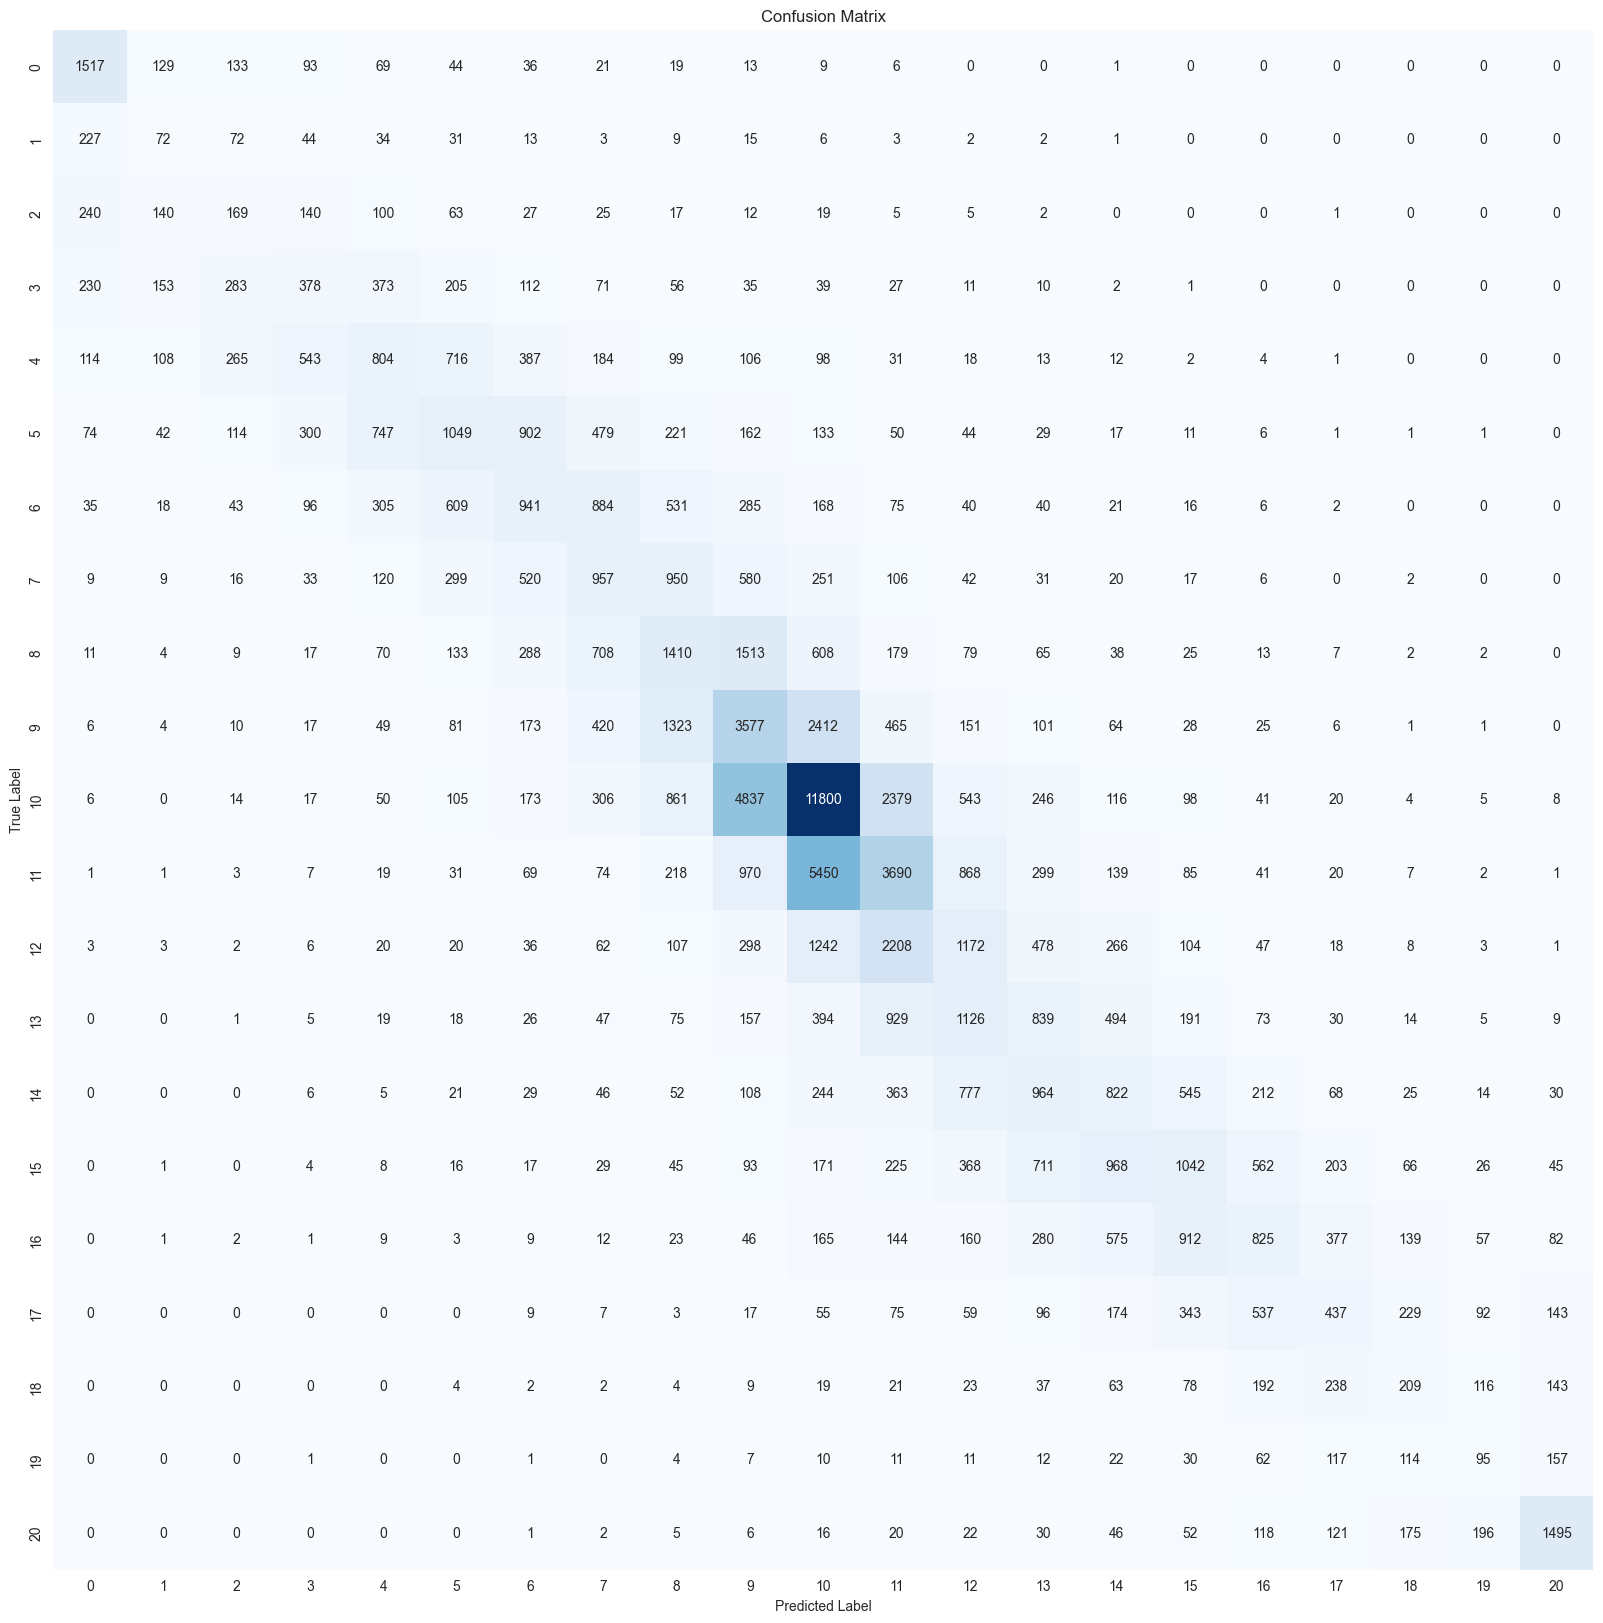

In [16]:
# Create the confusion matrix
conf_matrix = confusion_matrix(clip(y_val_rounded), clip(y_pred_val_rounded))

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Submit

In [17]:
y_pred=model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [18]:
output = pd.DataFrame({'FEN':test_df['FEN\tEvaluation'] ,
                       'Predicted_Evaluation': y_pred[:,0]})
output['FEN']=output['FEN'].apply(lambda x:x.replace('\t',''))
output.to_csv('submission.csv', index=False)
model.save('D:/AI/Chess/ChessApp/Chess/model/train/my_chess_eval_model1.h5')

In [19]:
output.head()

,FEN,Predicted_Evaluation
0,r2q1rk1/pb3pbp/1ppp1np1/2nPp3/4P3/2P1B2P/PPBNN...,-5.054074
1,r7/ppQ1n2p/2n1k1p1/1N1p1q2/1P1P4/2P3P1/P7/2K5 ...,-785.417969
2,r1bq1rk1/ppp1bppp/2n2n2/3Pp3/2B5/2PP1N1P/PP3PP...,-53.212521
3,6k1/R2b2r1/8/7R/2PPP3/8/7P/5K2 b - - 0 42,482.601807
4,r4r2/pp4pp/k1nQ1q2/5P2/2B5/8/P5PP/1R3RK1 b - -...,245.480713


# Make sure to upvote if you found this useful